全部数据计算完成


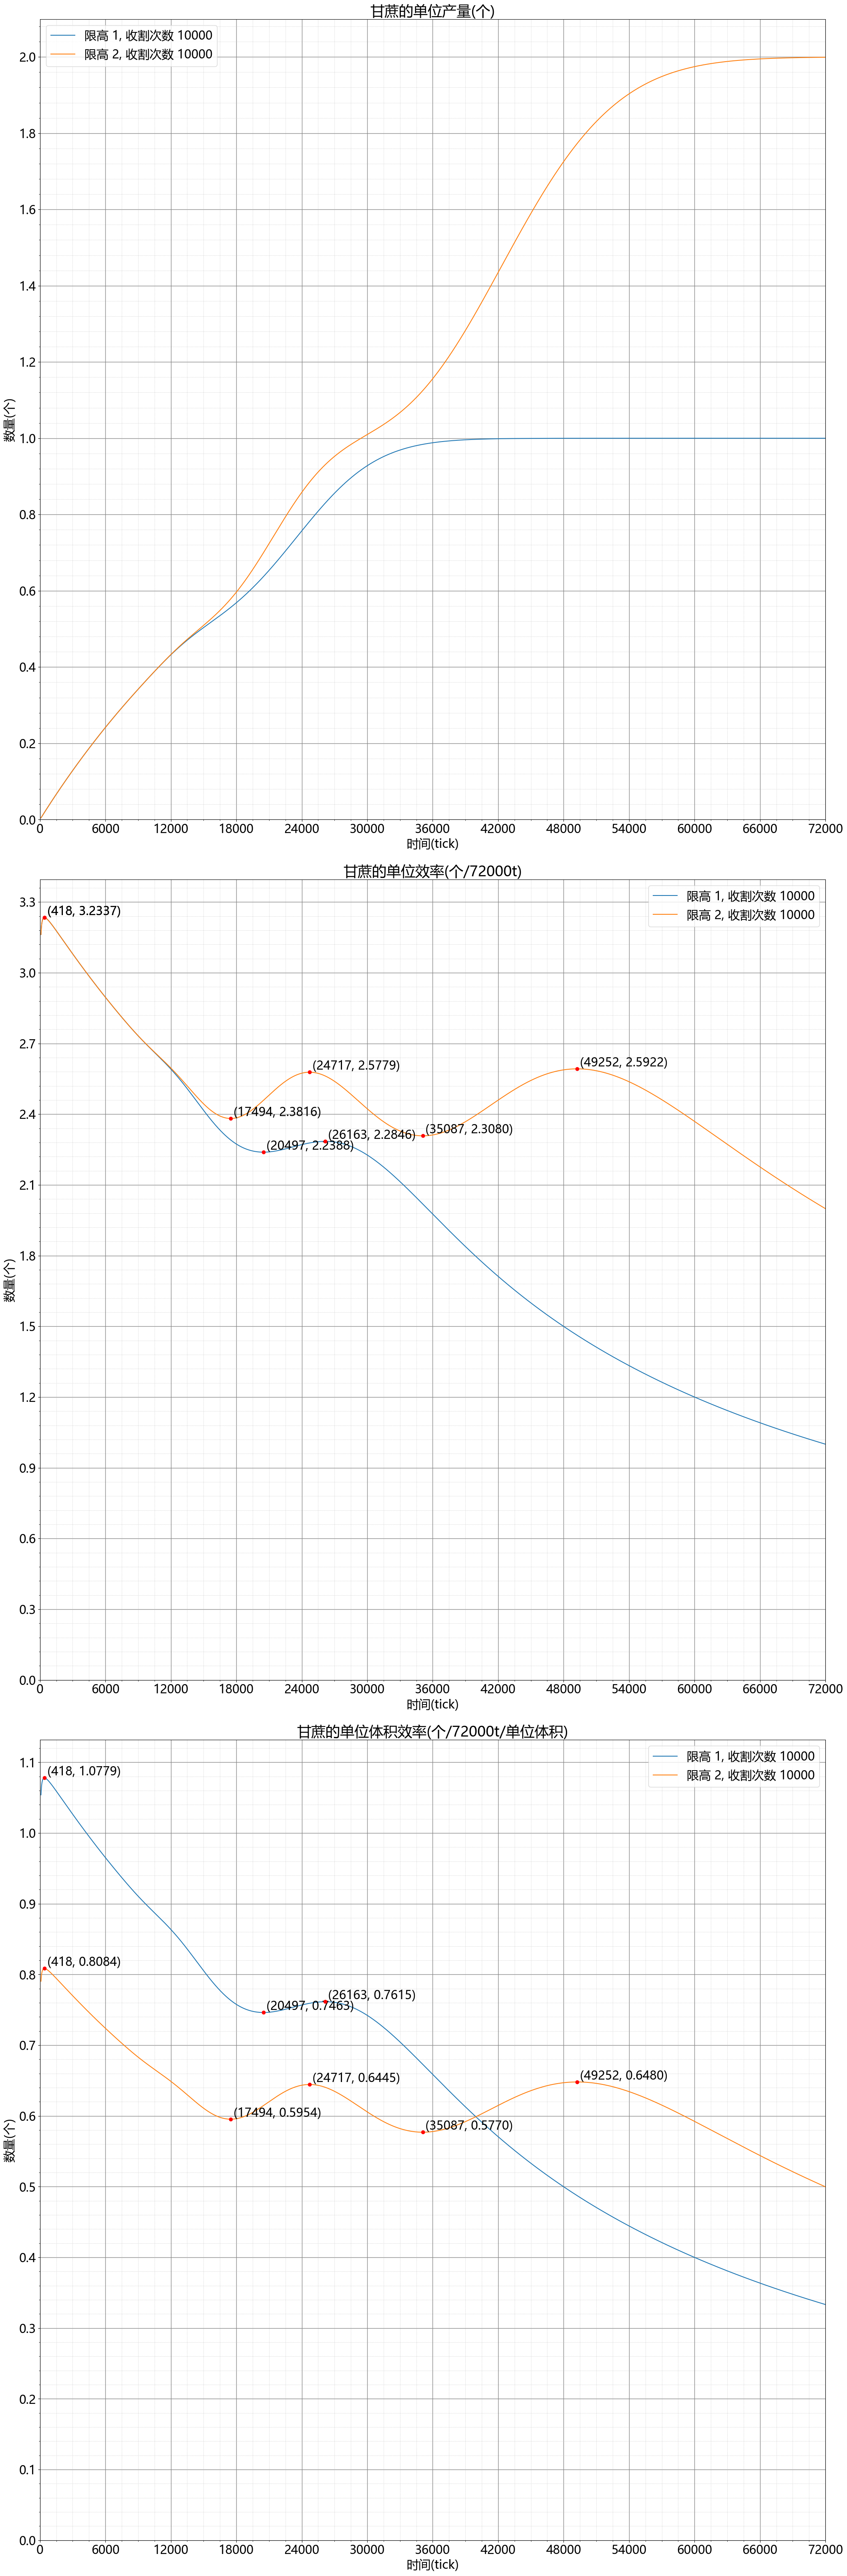

数据已画图导出为图像


In [2]:

import math
import numpy as np #基础库科学运算
import matplotlib.pyplot as plt # 画图
from matplotlib.ticker import MultipleLocator, MaxNLocator
import pandas as pd # 导出表格

# 1.1 条件参数
时间表 = list(range(100, 1+72000, 1)) # 时间数组，从1~72000tick遍历一遍每个时间节点的数据，也可以改成[12000,24000,36000]之类的需要的时间节点
产量放大系数 = 72000 # 算出来的数据(仅效率类，不包含产量)时间单位都是tick，所以数值非常小，可以放大72000被得到每小时的效率(不放大填1)

p = 1
age_count = 16 #每个生长一个高度要经历多少个阶段。例如：甘蔗age从0~15，达到15后再选中一次就生长一个高进入下一个循环，所以一共16个阶段

限高表 = [1,2] # 列出想看的限高情况，目前只有甘蔗和仙人掌，输入1,2就行了
收割表 = [10000] # 一万次收割保证数据收敛，如果感兴趣推荐你填[1,2,3,4,5]看看这些收割次数的数据，非常有意思
收割费时 = 4 # 收割造成的无法生长的时间，一般是粘性活塞粘液块加二档中继器为4tick；飞行器慢一些，算上往返应该是20tick
公摊高度 = 2
    # 每个甘蔗除了生长的必要空间之外的高度占用(例如不能收割的甘蔗根与其种植的方块)，1.17之后可以用苔藓块(不用考虑粘液块附着的问题)该数值为2。
    # 但是在1.17之前，由于收割用的粘液块要和甘蔗种植方块隔开，所以限高1和2的单位体积是一样的，此时单位体积效率就没有意义了。

# 1.2 输出参数
是否画图 = 1
标记图像极值点 = 1 # 填1或0代表是或否
图片像素尺寸 = 2160 # 单个图像的像素大小(边长)，这三个图像会拼成一个整图输出

是否导出Excel表格 = 0

# 2.初始化与计算
单位产量表 = []
单位效率表 = []
单位体积效率表 = []

for limited_height in 限高表:

    #2.1.1 状态总数
    states_count = age_count * limited_height + 1

    #2.1.2 初始状态矩阵 A
    A = np.zeros(states_count)
    A[-1] = 1 # A[0] = 1 一样会收敛到相同的曲线

    #2.1.3 状态转移矩阵 T
    P = np.zeros((states_count, states_count))
    for i in range(states_count):
        P[i, i] = 1 - p/4096
    for i in range(states_count - 1):
        P[i, i + 1] = p/4096
    P[-1, -1] = 1

    #2.1.4 收割矩阵 H
    H = np.zeros((states_count, states_count))
    for i in range(age_count):
        H[i, i] = 1
    for i in range(age_count, states_count):
        H[i, 0] = 1
    
    #2.2 遍历计算
    单位产量表_限高 = []
    单位效率表_限高 = []
    单位体积效率表_限高 = []
    for harvested in 收割表:
        单位产量表_限高_收割 = []
        单位效率表_限高_收割 = []
        单位体积效率表_限高_收割 = []
        for t in 时间表:
            P_3t = np.linalg.matrix_power(P, 3 * t)
            S = A @ np.linalg.matrix_power(P_3t @ H, harvested) @ P_3t
            product = 0 
            for height in range(limited_height):
                product += np.sum(height * S[(height * age_count):((height + 1) * age_count)])
            product += limited_height * S[states_count - 1]
            单位产量表_限高_收割.append(float(product))
            单位效率表_限高_收割.append(float(产量放大系数 * product / (t + 收割费时)))
            单位体积效率表_限高_收割.append(float(产量放大系数 * product / (t + 收割费时) / (limited_height + 公摊高度)))
        单位产量表_限高.append(单位产量表_限高_收割)
        单位效率表_限高.append(单位效率表_限高_收割)
        单位体积效率表_限高.append(单位体积效率表_限高_收割)
    单位产量表.append(单位产量表_限高)
    单位效率表.append(单位效率表_限高)
    单位体积效率表.append(单位体积效率表_限高)
print("全部数据计算完成")


# 3. 画图
if 是否画图:
    # 3.1.1 找极值点函数
    def find_extrema(data, rel_tol=1e-10):
        extrema_indices = []
        for i in range(1, len(data) - 1): # 遍历数据，跳过第一个和最后一个元素，因为它们没有足够的邻值进行比较
            if not math.isclose(data[i], data[i - 1], rel_tol=rel_tol) and \
            not math.isclose(data[i], data[i + 1], rel_tol=rel_tol):# 检查当前值与相邻值的接近性
                if (data[i] > data[i - 1] and data[i] > data[i + 1]) or \
                (data[i] < data[i - 1] and data[i] < data[i + 1]): # 判断是否为极值点
                    extrema_indices.append(i)
        return extrema_indices

    # 3.1.2 找列表最大值函数
    def find_max_value(data):
        if isinstance(data, list): # 如果数据是列表，递归地查找每个元素的最大值
            return max(find_max_value(item) for item in data) # 如果数据不是列表，直接返回该值
        else:
            return data

    # 3.1.2 画图设置函数
    def plot_set(ax, title, xlabel, ylabel, xdata, ydata):
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(0, max(xdata))
        ax.set_ylim(0, 1.05*find_max_value(ydata))
        ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
        ax.xaxis.set_minor_locator(MaxNLocator(nbins=60))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=12))
        ax.yaxis.set_minor_locator(MaxNLocator(nbins=60))
        ax.grid(which='major', axis='x', linestyle='-', linewidth=1, color='#888888')
        ax.grid(which='minor', axis='x', linestyle=':', linewidth=0.5, color='#aaaaaa')
        ax.grid(which='major', axis='y', linestyle='-', linewidth=1, color='#888888')
        ax.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, color='#aaaaaa')
        ax.legend()
    
    # 3.1.3 画图函数
    def plot_data(ax, data, current_height, harvested_times, 此图标记极值点=False):
        ax.plot(时间表, data, label=f'限高 {current_height}, 收割次数 {harvested_times}') # 绘制数据的曲线
        if 此图标记极值点 and 标记图像极值点: # 标记极值点
            extrema_indices = find_extrema(data)
            for idx in extrema_indices:
                ax.scatter(时间表[idx], data[idx], color='red', zorder=5)
                ax.annotate(f'({时间表[idx]}, {data[idx]:.4f})',
                            xy=(时间表[idx], data[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize = picture_inch_size)

    # 3.2 画图
    picture_inch_size = 图片像素尺寸 / 100 # matplotlib使用英寸参数，DPI默认为100，也就是1英寸=100像素
    plt.rcParams['font.family'] = 'Microsoft YaHei' # 你得找个中英文都支持的字体，否则中文或英文字符会显示为方框
    plt.rcParams['font.size'] = picture_inch_size  # 字体尺寸
    fig, axs = plt.subplots(3, 1, figsize=(picture_inch_size, 3 * picture_inch_size))  # 单个图最后排成3行1列

    for height_idx, height in enumerate(限高表):
        for harvested_idx, harvested in enumerate(收割表):
            plot_data(axs[0], 单位产量表[height_idx][harvested_idx], height, harvested, 此图标记极值点=False)
    plot_set(axs[0], f'甘蔗的单位产量(个)', '时间(tick)', '数量(个)', 时间表, 单位产量表)

    for height_idx, height in enumerate(限高表):
        for harvested_idx, harvested in enumerate(收割表):
            plot_data(axs[1], 单位效率表[height_idx][harvested_idx], height, harvested, 此图标记极值点=True)
    plot_set(axs[1], f'甘蔗的单位效率(个/{产量放大系数}t)', '时间(tick)', '数量(个)', 时间表, 单位效率表)
    
    for height_idx, height in enumerate(限高表):
        for harvested_idx, harvested in enumerate(收割表):
            plot_data(axs[2], 单位体积效率表[height_idx][harvested_idx], height, harvested, 此图标记极值点=True)
    plot_set(axs[2], f'甘蔗的单位体积效率(个/{产量放大系数}t/单位体积)', '时间(tick)', '数量(个)', 时间表, 单位体积效率表)

    # 3.3 绘制图像并导出
    plt.tight_layout()
    plt.savefig(f'甘蔗的数据图像(收割费时{收割费时}t).png', dpi=100, bbox_inches='tight')
    plt.show()
    print("数据已画图导出为图像")



# 4 数据导出到Excel表格
if 是否导出Excel表格:
    # 4.1 添加数据的函数
    def export_to_excel(sheet_name, data_table):
        all_data = [] # 存储所有数据
        for i, 限高_Excel in enumerate(限高表): # 遍历每个限高
            time_row = [f'时间(限高：{限高_Excel})'] + 时间表  # 每个限高前添加时间列的标题
            all_data.append(time_row) # 添加当前限高的时间列，包含限高信息
            for j, h in enumerate(收割表): # 添加当前限高的收割轮数数据
                row_data = [f'收割{h}次'] # 创建一行数据，包含收割次数
                row_data += [data_table[i][j][k] for k in range(len(时间表))] # 添加该限高下的所有时间对应的收割数据
                all_data.append(row_data)  # 将当前行添加到总数据中
            empty_row = [''] * len(time_row)  # 确保空行的长度与时间行一致
            all_data.append(empty_row)  # 添加空行
        df = pd.DataFrame(all_data) # 创建 DataFrame 来存储所有数据
        df = df.T # 转置 DataFrame
        df.to_excel(writer, sheet_name=sheet_name, index=False, header=False) # 将转置后的 DataFrame 导出到指定的工作表

    #4.2 使用 ExcelWriter 导出数据
    with pd.ExcelWriter(f'甘蔗的数据表(收割费时{收割费时}t).xlsx', engine='openpyxl') as writer:
        export_to_excel('单位产量', 单位产量表)
        export_to_excel('单位效率', 单位效率表)
        export_to_excel('单位体积效率', 单位体积效率表)
        column_width = 16 # 设置列宽和冻结窗格
        for sheet_name in ['单位产量', '单位效率', '单位体积效率']:
            worksheet = writer.sheets[sheet_name]
            worksheet.freeze_panes = 'A2' # 冻结第一行
            for column in worksheet.columns: # 设置列宽
                column_letter = column[0].column_letter
                worksheet.column_dimensions[column_letter].width = column_width
    print("数据已导出为Excel表格")

# 结束
